<img src="./pic/sharif-main-logo.png" alt="SUT logo" width=345 height=345 align=left class="saturate">


<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 - Unsupervised Learning<br>
<font color=696880 size=4>
    Assignment Supervisor: Niki Sepasian <br>
<font color=696880 size=5>
    Asemaneh Nafe


In [1]:
student_number = 'Asemaneh'
full_name = 'Nafe'
assert student_number and full_name is not None, 'please input your information'

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

<font color=red size=3>
notice that you can not use sklearn.decomposition and sklearn.cluster libary in this home work! you should implement pca and kmeans from scratch.

## Overview
In this assignment, you will perform PCA and K-Means clustering on credit card customer data. dataset contains information about customer’s use of credit cards. The goal is to reduce the dataset’s dimensionality using PCA and then apply clustering to segment customers. You will compare the clustering performance both before and after PCA. Additionally, you'll be asked to explain the theory and decisions behind each step.

## Data Preprocessing
Read the cc_general.CSV file and display a few samples.

In [3]:
df = pd.read_csv('dataset.csv')
print(df.head())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

Display dataset information.

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Which column do you think might be the most irrelevant for PCA and clustering?
Answer:
Non-numeric data or identifiers, like CUST_ID, should be removed, as they don't carry useful information for these tasks.

In [5]:
# Exclude irrelevant feature
df = df.select_dtypes(include=[float, int])
print(df.head())

       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                

how do you handle missing data, and why did you choose this method?
Answer:
In this dataset, filling missing values with the median is a good choice because the median is robust to outliers, which are common in financial datasets. Imputing missing values this way helps to retain the overall distribution of the data without significantly distorting it.

In [6]:
#Fill missing data
df.fillna(df.median(), inplace=True)

plot the correlation matrix and identify redundant features.remove them from the dataframe.

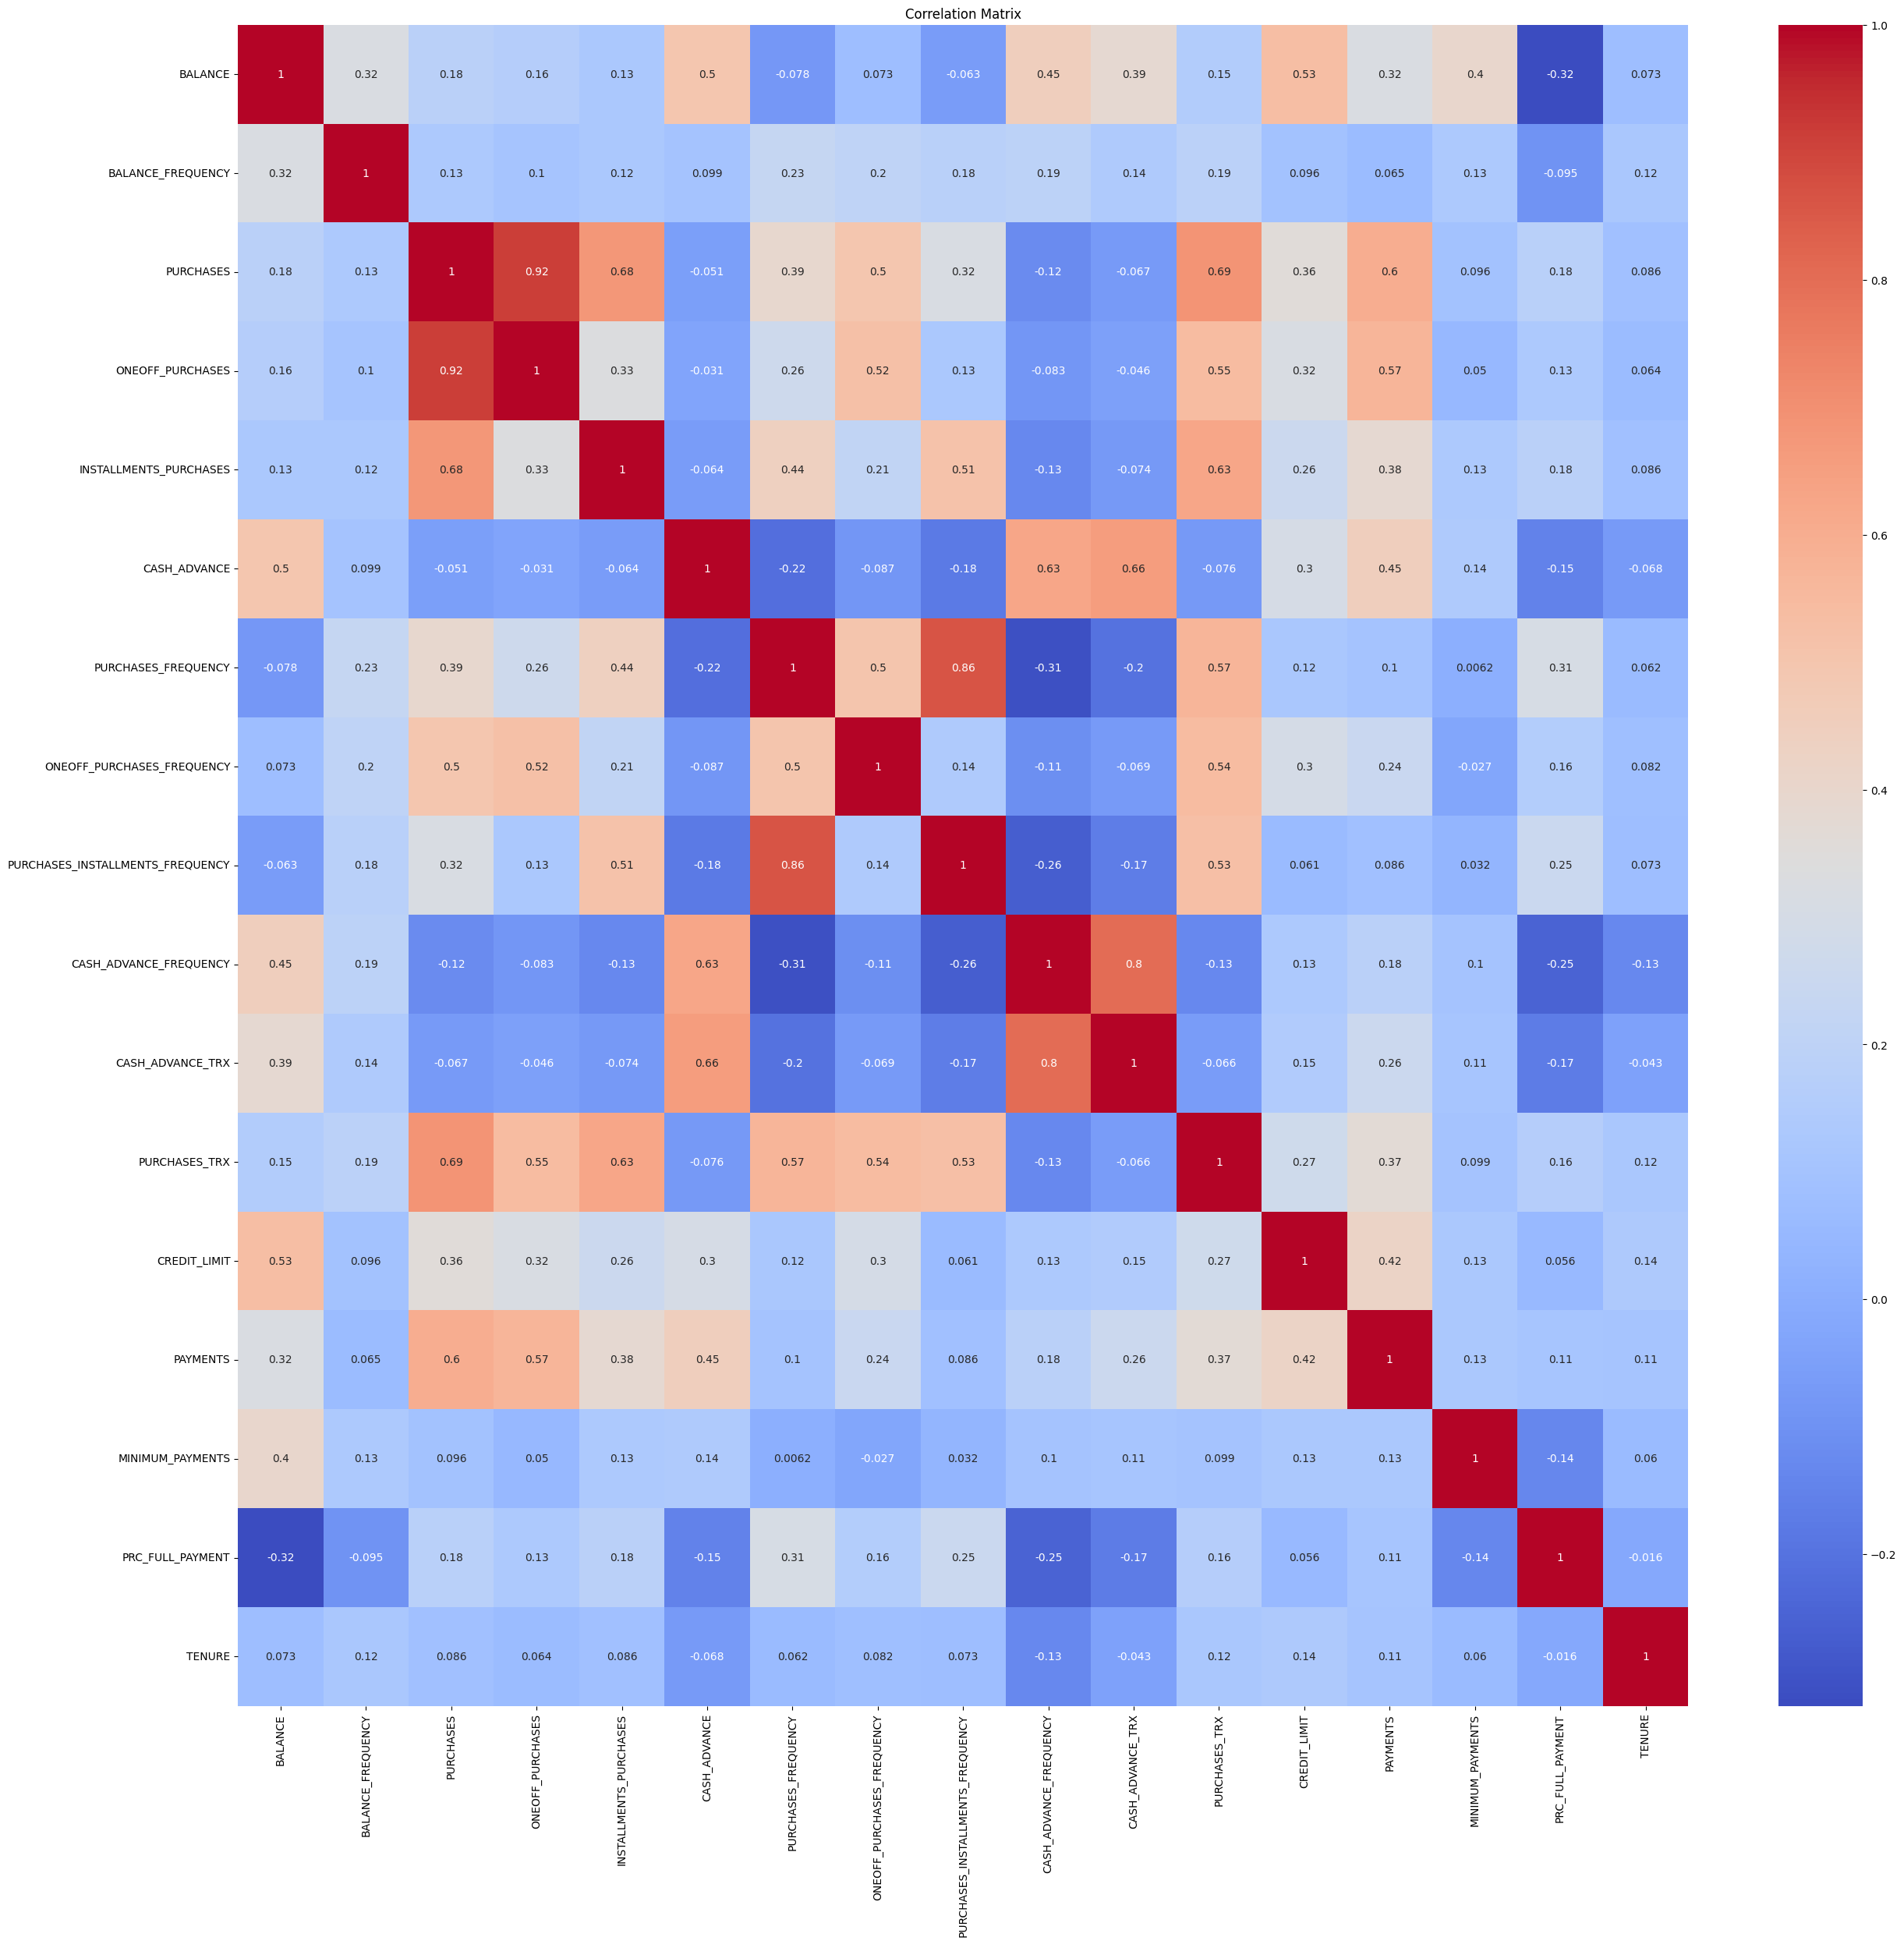

In [7]:
# Plot the correlation matrix
plt.figure(figsize=(30, 28))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Identify and remove redundant features. use 0.8 threshold.
correlation_matrix = df.corr()
def identify_redundant_features(correlation_matrix, threshold=1):
    redundant_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                redundant_features.add(colname)

    return redundant_features

redundant_features = identify_redundant_features(correlation_matrix, threshold=0.8)
print("Redundant features:", redundant_features)
df = df.drop(columns=redundant_features)

Redundant features: {'PURCHASES_INSTALLMENTS_FREQUENCY', 'ONEOFF_PURCHASES'}


## Standardize the Data
Standardize the dataset using z-score normalization

In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

Why is it important to standardize the data before applying PCA?
<br>
Answer:
Standardization is crucial before applying PCA because PCA is sensitive to the scale of the data. Features with larger scales will dominate the principal components, which can skew the analysis. Standardizing ensures that all features contribute equally to the PCA, enabling better dimensionality reduction and interpretation of the principal components.
KMeans algorithm may end up giving disproportionately greater weight to features with higher magnitudes and may be unaware of features with lower magnitudes but equally important.

What is differnce between Normalizer and StandardScaler classes. which is better for PCA?
<br>
Answer:
Normalizer: Normalizes each sample (row) to have a unit norm (L1, L2, or max norm).
StandardScaler: Standardizes each feature (column) to have a mean of 0 and a standard deviation of 1 (Z-score normalization).
<br>
If variance of one variable is higher than others we make the pca components biased in that direction. So, best thing to do is make the variance of all variables the same. One way of doing this is by standardizing all the variables. Normalization does not make all variables to have the same variance.

## Principal Component Analysis (PCA)
Implement PCA from scratch.

In [10]:
class CustomPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        covariance_matrix = np.cov(X_centered, rowvar=False)

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        if self.n_components is None:
            self.n_components = X.shape[1]

        self.components = eigenvectors[:, :self.n_components]
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues[:self.n_components] / total_variance

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def get_explained_variance_ratio(self):
        return self.explained_variance_ratio

    def get_components(self):
        return self.components

### Visualizing the Cumulative Variance

Plot the cumulative explained variance to visualize the selection of components.  How many components are needed to explain 75% of the variance?
answer: 6

[ 25.4  47.7  56.4  63.9  70.5  76.1  81.4  85.7  89.4  92.5  94.5  96.2
  97.8  99.  100. ]


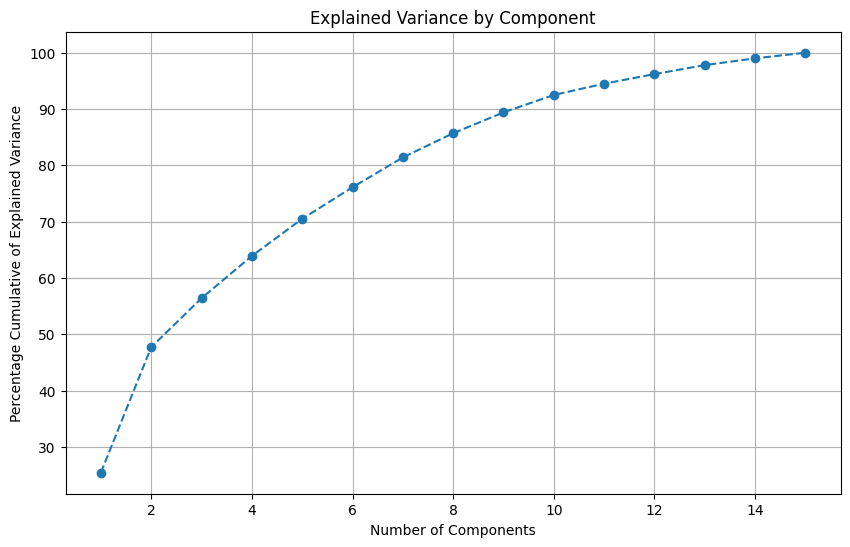

In [11]:
pca = CustomPCA()
pca.fit(scaled_data)
per_var = np.round(pca.get_explained_variance_ratio()*100, decimals = 1)
print(per_var.cumsum())

plt.figure(figsize = (10,6))
plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--")
plt.grid()
plt.ylabel("Percentage Cumulative of Explained Variance")
plt.xlabel("Number of Components")
plt.title("Explained Variance by Component")
plt.show()

Build a new DataFrame with the first slected components.

In [12]:
#Build a new DataFrame with the first slected components
selected_components = 6
pca = CustomPCA(selected_components)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)

df_pca = pd.DataFrame(scores_pca, columns=[f'PC{i+1}' for i in range(selected_components)])
print(df_pca.head())

        PC1       PC2       PC3       PC4       PC5       PC6
0  1.731242  0.824084 -0.384320 -0.451623 -0.087766  0.438057
1  0.301398 -2.533638  0.621582 -0.939313 -0.794456  0.060615
2 -1.194199  0.887568 -1.184455  1.129115 -1.152626 -1.869029
3  0.930140  0.030106 -0.111213 -1.309452 -0.505452 -0.834667
4  1.499511  0.517780 -0.794300 -0.125376 -0.253049  0.326998


We expect these new features to be orthogonal to each other. Check this and show the correlation between the features.

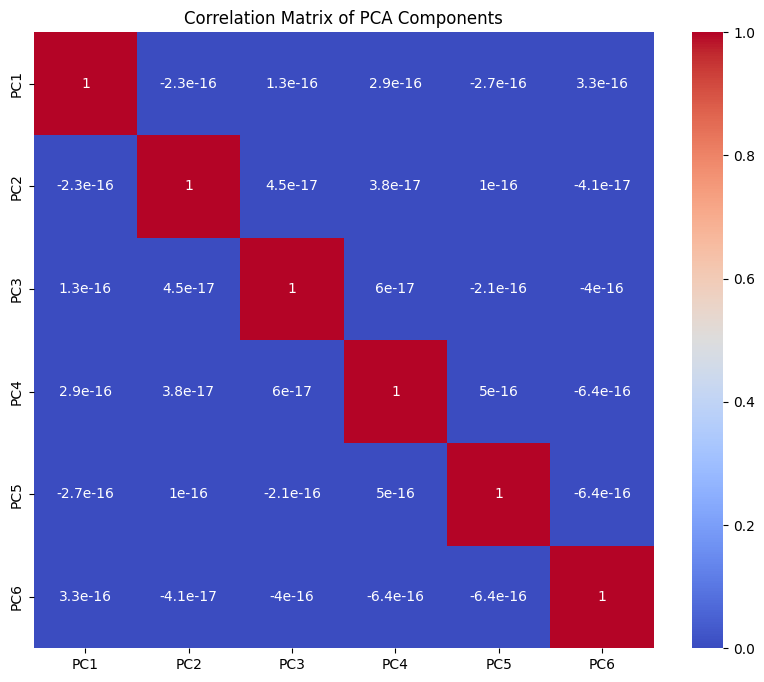

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_pca.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of PCA Components')
plt.show()

## KMeans
Implement kmeans from scratch.

In [14]:
class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.inertia_ = None
        self.labels_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        # Randomly initialize centroids
        random_indices = np.random.permutation(X.shape[0])
        self.centroids = X[random_indices[:self.n_clusters]]

        for i in range(self.max_iter):
            # Assign clusters
            distances = self._compute_distances(X)
            self.labels_ = np.argmin(distances, axis=1)

            # Recompute centroids
            new_centroids = np.array([X[self.labels_ == j].mean(axis=0) for j in range(self.n_clusters)])

            # Stop if centroids don't change
            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

        # Calculate inertia (WCSS)
        self.inertia_ = self._calculate_inertia(X)
        return self

    def _compute_distances(self, X):
        # Compute distances between each point and the centroids
        return np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)

    def _calculate_inertia(self, X):
        # Sum of squared distances of samples to their closest cluster center
        inertia = 0
        for i in range(self.n_clusters):
            cluster_points = X[self.labels_ == i]
            inertia += np.sum((cluster_points - self.centroids[i])**2)
        return inertia

### Elbow Method
Apply the elbow method to determine the optimal number of clusters for K-Means. what is the best number of clusters?

In [15]:
#put the seed state 42
WCSS = []

for i in range(1,30):
  kmeans_pca = CustomKMeans(n_clusters = i, random_state = 42)
  kmeans_pca.fit(scores_pca)
  WCSS.append(kmeans_pca.inertia_)

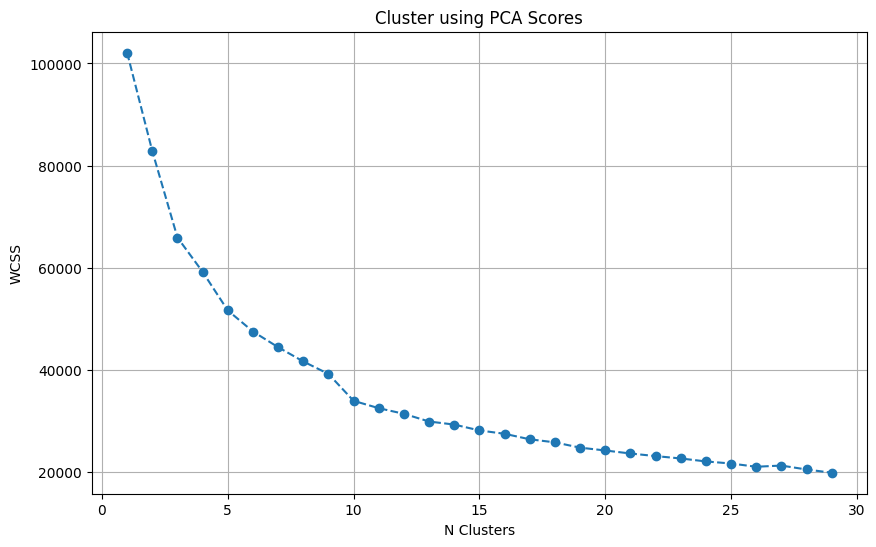

In [16]:
plt.figure(figsize = (10,6))
plt.plot(range(1,30), WCSS, marker = "o", linestyle = "--")
plt.grid()
plt.title("Cluster using PCA Scores")
plt.ylabel("WCSS")
plt.xlabel("N Clusters")
plt.show()

Apply the optimal KMeans clustering on the PCA-transformed data, and assign cluster labels to each observation. Add a new column named segment to the df_pca DataFrame to store these labels.

In [17]:
# Apply KMeans on PCA-reduced data
kmeans_pca = CustomKMeans(n_clusters = 5, random_state = 42)
kmeans_pca.fit(scores_pca)

# Seting the cluster label to each observation, using the atribute .labels_
df_pca["segment"] = kmeans_pca.labels_

 visualize the clustering by plotting the pairwise relationships of the PCA-reduced features, color-coded by the cluster assignments.

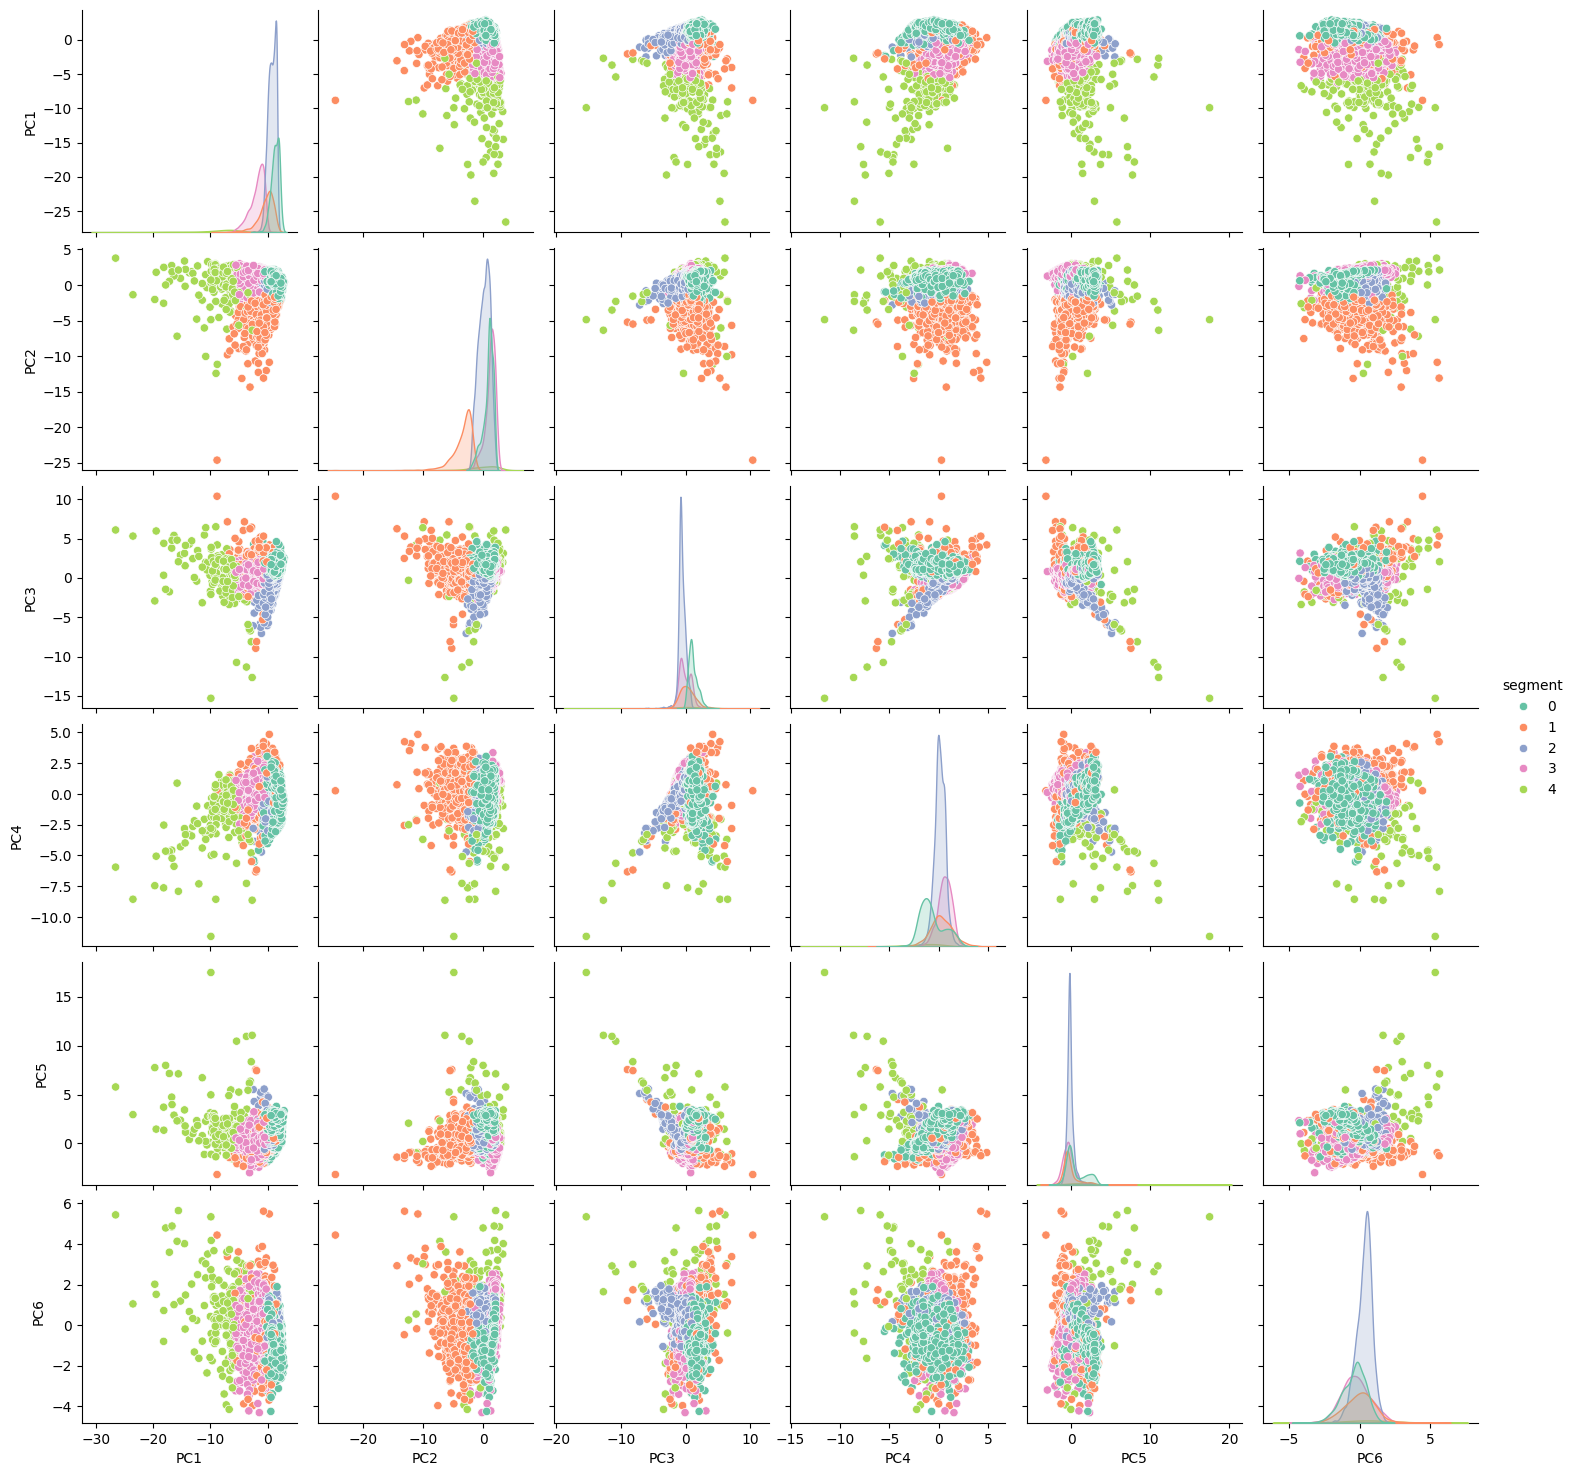

In [18]:
sns.pairplot(df_pca[0:], hue='segment', palette='Set2')

So, when we employ PCA prior to using K-means we can visually separate almost the entire data set. That was one of the biggest goals of PCA - to reduce the number of variables by combining them into bigger, more meaningful features.

### Hierarchical Clustering
Perform hierarchical clustering on the reduced dataset after PCA. use complete linkage method.


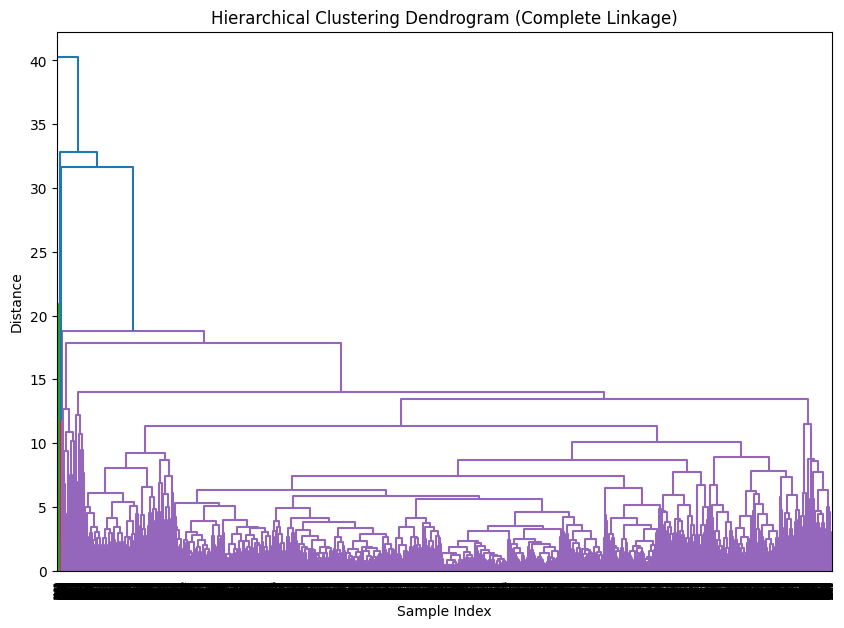

In [19]:
# Perform Hierarchical Clustering on the original dataset (first four attributes)
Z = linkage(scores_pca, method='complete')

# Visualize the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

Use scipy.cluster.hierarchy.fcluster to assign clusters from the dendrogram(use 5 cluster). then visualize the results using pairplots.

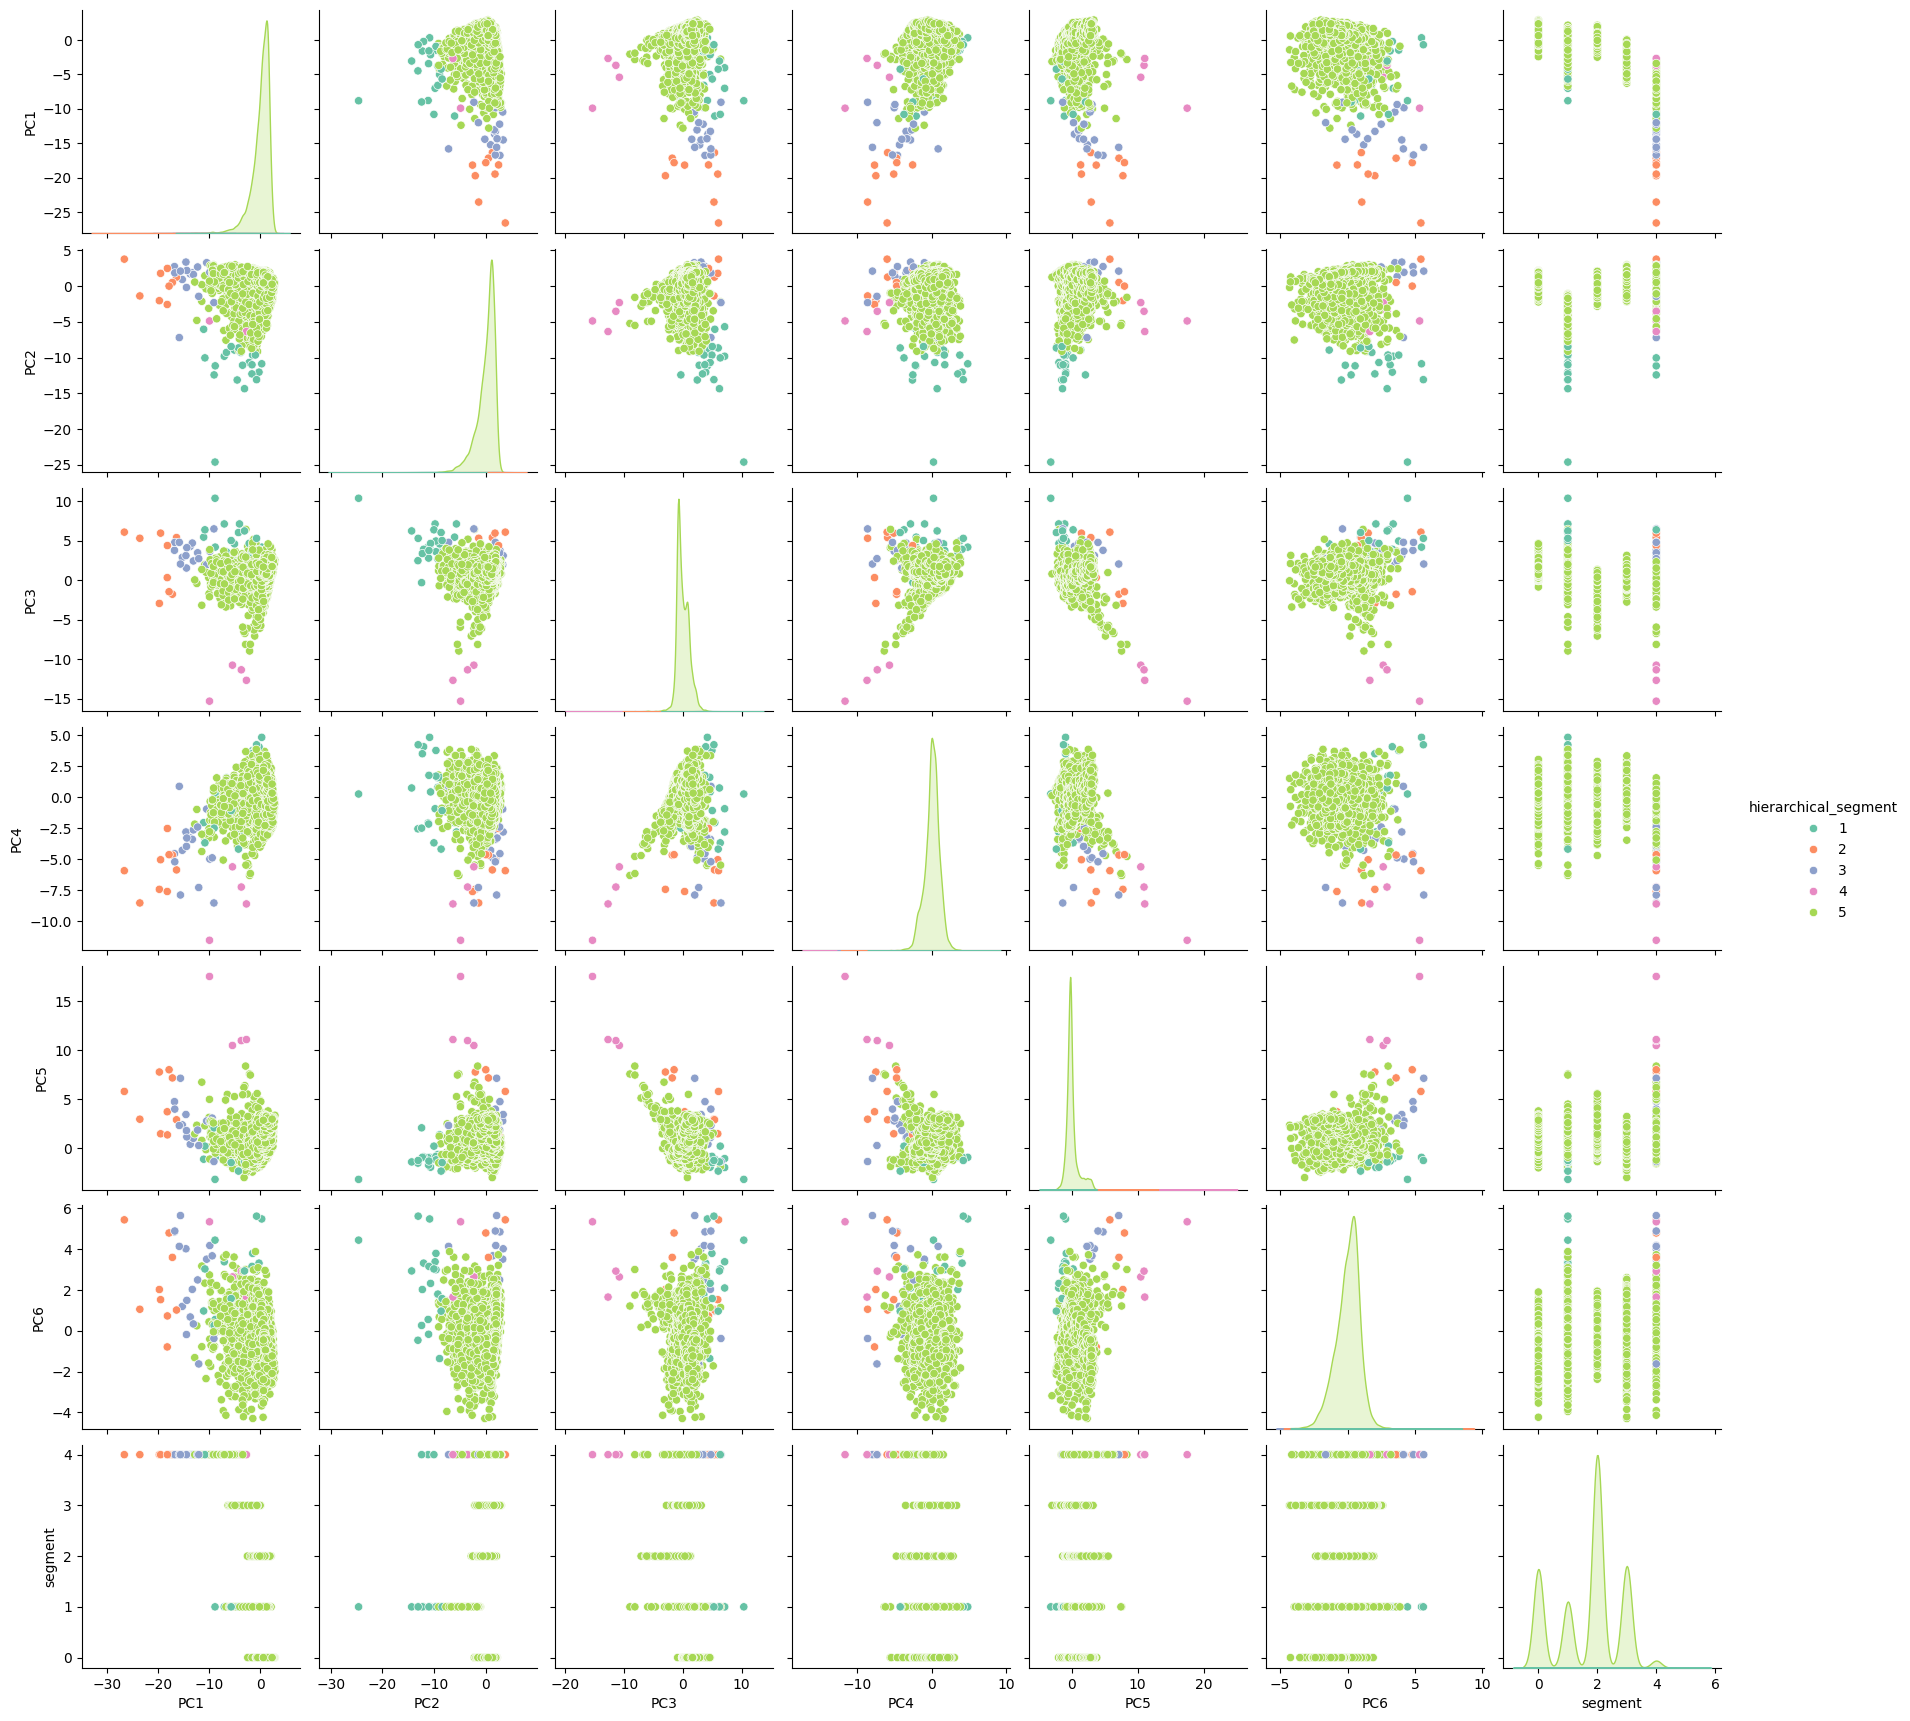

In [20]:
# Choose distance threshold and assign clusters
clusters_hierarchical_pca = fcluster(Z, t=5, criterion='maxclust')

# Assign cluster labels to PCA DataFrame
df_pca["hierarchical_segment"] = clusters_hierarchical_pca

# Visualize using PCA components
sns.pairplot(df_pca, hue='hierarchical_segment', palette='Set2')
plt.show()